In [249]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster, linkage
from dateutil.relativedelta import relativedelta
from datetime import datetime
from PIL import Image
import requests
from io import BytesIO
from shapely.geometry import Point

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200

Assuming that the dataset is already loaded before.

In [250]:
date  = "2023-12-10"
url  = f"https://data.insideairbnb.com/united-kingdom/england/london/{date}/data/listings.csv.gz"
path = os.path.join('data','raw')
fn   = url.split('/')[-1]
df = pd.read_csv(os.path.join(path,fn), low_memory=False)

print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 91,778 x 75


<Axes: >

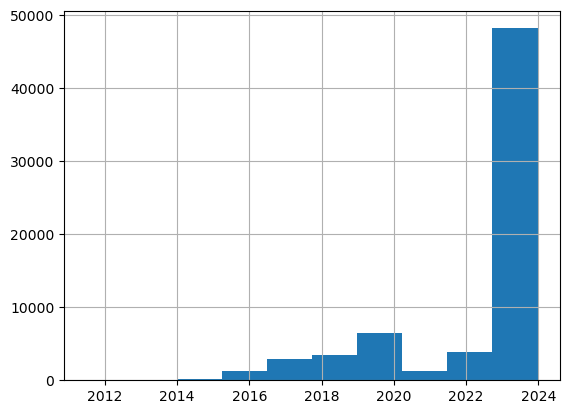

In [251]:
df['last_review'] = pd.to_datetime(df['last_review'])
date = datetime.strptime(date, "%Y-%m-%d")
df.last_review.hist()

In [252]:
df.last_review.isnull().value_counts()

last_review
False    67655
True     24123
Name: count, dtype: int64

In [253]:
"""
Converting review column to datetime, and selecting only the recently active listings. 
We also take Null values, because these might be new listings without reviews.
"""
df = df[(df['last_review'] > (date - relativedelta(years=1))) | (df['last_review'].isnull())]

print(f"Data frame after filtering last review date is {df.shape[0]:,} x {df.shape[1]}")

Data frame after filtering last review date is 70,872 x 75


Making the same cleaning as in the base file.

In [254]:
df[~(df.price.str.startswith('$', na=False))]
money = ['price']
for m in money:
    df[m] = df[m].str.replace(r'[$,]', '', regex=True).astype('float')
df_valid = df[~df['price'].isna()] # rows where price is valid

ints  = ['id', 'host_id', 'host_total_listings_count', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews']

for i in ints:
    try:
        df[i] = df[i].astype('float').astype('int')
    except ValueError as e:
        #print("  - !!!Converting to unsigned 16-bit integer!!!")
        df[i] = df[i].astype('float').astype(pd.UInt16Dtype())

print(f"Data frame is {df_valid.shape[0]:,} x {df_valid.shape[1]}")

Data frame is 68,146 x 75


Looking for duplicates:

In [259]:
def find_duplicates(df_valid):
    """
    The function looks at hosts with multiple listings and checks if they are within 300m radius (150m max location scattering as per Airbnb's anonymisation algorithm, x2).
    It then estimates the number of genuine homes within the cluster.
    
    Returns a gdf with new columns: 
    'cluster_id' - each unique value is a cluster
    'easting', 'northing' - used in calculating the proximity of listings
    'prvt_rms_in_cluster','entr_hms_in_cluster' - summarises N of private rooms and entire homes within the cluster
    'genuine', 'true_nrooms' - boolean column, and int column, with the following assumptions:

    If the cluster has 0 entire homes, and N rooms, first room will be "converted" to an entire home, and the rest will be discarded. 
    The location of the point will be amended to represent centrepoint of all rooms in the cluster.
    Record of the N of rooms will stay in col "true_nrooms"
    If the cluster has rooms and entire homes, the homes will be treated as genuine homes, and rooms treated as duplicates of the genuine home. 
    With the current timeframes, further enquiries into uniqueness of homes vs rooms inside each cluster is not feasible.
    """
    """
    We are looking for duplicates among multi-listing hosts. First, we filter by listings_count > 1.
    """
    finddups = df_valid[df_valid["host_listings_count"] > 1]
    print(f"There are {finddups.shape[0]} listings from multi-lister hosts")
    
    """
    I convert the df into gdf, reproject into EPSG 27700, and put easting and northing into new columns.
    """
    finddupsgdf = gpd.GeoDataFrame(finddups,
          geometry=gpd.points_from_xy(finddups.longitude, finddups.latitude, crs='epsg:4326'))
    
    finddupsgdf = finddupsgdf.set_crs('EPSG:4326', allow_override=True)
    finddups = finddupsgdf.to_crs('EPSG:27700', inplace=True)
    # print(finddupsgdf.crs)
    # finddupsgdf.plot()
    
    finddupsgdf['easting'] = finddupsgdf.geometry.x
    finddupsgdf['northing'] = finddupsgdf.geometry.y
    
    """
    I perform cluster analysis and mark listings from the same host that are within 300m from each other 
    (150m max location scattering as per Airbnb's anonymisation algorithm, x2). They constitute a cluster, and we then assess if they are a duplicate or not.
    The selected method computes pairwise distances  can calculate the distance matrix between all points in a group. 
    Before this method I tried KNN, but the listings were paired incorrectly. 
    cdist solved this, and it is relatively light on small groups (our dataset is large, but it is split into small groups - by host).
    """
    # Initialize a column for cluster IDs
    finddupsgdf['cluster_id'] = None
    
    # Process each host group
    for host_id, group in finddupsgdf.groupby("host_id"):
        if len(group) > 1:  # Only proceed if there is more than 1 listing
            coords = group[['easting', 'northing']].to_numpy()
            
            # Calculate pairwise distances using pdist (returns condensed distance matrix)
            dist_matrix = pdist(coords)
            
            # Perform hierarchical clustering using the condensed distance matrix
            linkage_matrix = linkage(dist_matrix, method='single')
            clusters = fcluster(linkage_matrix, t=300, criterion='distance')
            
            # Assign clusters back to the original GeoDataFrame
            finddupsgdf.loc[group.index, 'cluster_id'] = [f"{host_id}-{cluster}" for cluster in clusters]
        else:
            finddupsgdf.loc[group.index, 'cluster_id'] = None  # Single point, no clustering
    
    #creating gdf with clusters only
    finddupsgdf = finddupsgdf[~finddupsgdf['cluster_id'].isna()]
    finddupsgdf = finddupsgdf.loc[finddupsgdf.duplicated(subset='cluster_id', keep=False)]
    
    print(f"Found {len(set(finddupsgdf.cluster_id))} clusters with {len(finddupsgdf)} listings within these clusters.")
    
    """
    I calculate N of entire homes and rooms in each cluster.
    Limitation found during EDA: "bedrooms" column in InsideAirbnb differs between scrapes. 
    "2023-12-10" scrape has NaN values in this column, while "2024-09-06" scrape has full data.
    For both datasets, we use "beds" column as a substitute, because airbnb2024.bedrooms.median()/airbnb2024.beds.median() = 1
    """
    # Initialize the columns
    finddupsgdf['prvt_rms_in_cluster'] = None
    finddupsgdf['entr_hms_in_cluster'] = None
    
    # Loop through each cluster by cluster_id
    for i, group in finddupsgdf.groupby("cluster_id"):
        # Count number of entire homes and private rooms in the group
        n_entire_homes = group[group['room_type'] == 'Entire home/apt'].shape[0]
        n_private_rooms = group[group['room_type'] == 'Private room'].shape[0]
    
        # Assign these counts back to the original DataFrame
        finddupsgdf.loc[group.index, 'entr_hms_in_cluster'] = n_entire_homes
        finddupsgdf.loc[group.index, 'prvt_rms_in_cluster'] = n_private_rooms
    
    # null values in N of bedrooms will interfere with our analysis, therefore we drop them
    finddupsgdf = finddupsgdf[finddupsgdf.beds.notna()]
    print(f"Data frame after filtering bedrooms Nans is {len(finddupsgdf)} listings long")
    
    finddupsgdf['true_nrooms'] = finddupsgdf['beds'] #fill with these values for now
    for i, group in finddupsgdf.groupby("cluster_id"):
        # If there are no "Entire home/apt" listings, only rooms. We assume they combine into an entire home, or are a large-scale commercial let
        if (group['entr_hms_in_cluster'] == 0).any(): #using any because the values are the same within the group
            finddupsgdf.loc[group.index, 'true_nrooms'] = len(group)
    
    #finddupsgdf.true_nrooms.hist(range={1,10})
    
    print(f"There are {finddupsgdf[finddupsgdf['true_nrooms'] > 6].shape[0]} listings that are within clusters with more than 6 listings in each. These are likely to be flats converted to holiday accommodation. We are leaving them in for the purpose of the exercise. They belong to {len(set(finddupsgdf[finddupsgdf['true_nrooms'] > 6].host_id))} unique host IDs.")
    """
    I then determine whether listings are genuine unique homes, or rooms from one entire home.
    If the cluster has 0 entire homes, and N rooms, first room will be "converted" to an entire home, and the rest will be discarded.
    Record of the N of rooms will stay in col "true_nrooms"
    If the cluster has rooms and entire homes, the homes will be treated as genuine homes, and rooms treated as duplicates of the genuine home
    """
    finddupsgdf['genuine'] = None
    
    for cluster_id, group in finddupsgdf.groupby("cluster_id"):
        num_entire_homes = (group['room_type'] == 'Entire home/apt').sum()
        
        if num_entire_homes == 0:
            # If only rooms are in the cluster
            finddupsgdf.loc[group.index, 'genuine'] = False  # Mark all as duplicates
            first_room_idx = group.index[0]  # Pick the first room as genuine
            finddupsgdf.loc[first_room_idx, 'genuine'] = True  # First room becomes the genuine home
            """ ... but the geometry is replaced with centroid x and y. 
            Without this the point and all associated rooms can be aggregated by different spatial unit, considering the scale of the location approximation (up to 150m from origin)"""
            dissolved_geometry = group.geometry.union_all()  # Combine all geometries in the group
            centroid = dissolved_geometry.centroid # Get the centroid of the combined geometry
            finddupsgdf.at[first_room_idx, 'geometry'] = Point(centroid.x, centroid.y)
        else:
            # Cluster has both rooms and entire homes
            finddupsgdf.loc[group.index, 'genuine'] = False  # Default all to duplicates
            entire_home_indices = group[group['room_type'] == 'Entire home/apt'].index
            finddupsgdf.loc[entire_home_indices, 'genuine'] = True  # Mark entire homes with true

    # write valid data to be used in further analysis
    # fn = {date}+"inside_airbnb_clean.csv"
    # path = os.path.join('data','inside_airbnb')
    
    # if not os.path.exists(path):
    #     print(f"Creating {path} under {os.getcwd()}")
    #     os.makedirs(path)
        
    # df_valid.to_file(os.path.join(path,fn), index=False)

    print(f"The clustering exercise identified {len(finddupsgdf[finddupsgdf['genuine'] == False])} listings that are potentially duplicates of other listings.")
    #print(f"The gdf has been saved into {path}")

    return finddupsgdf

In [260]:
df_valid_nodups = find_duplicates(df_valid)

There are 41847 listings from multi-lister hosts
Found 8629 clusters with 29253 listings within these clusters.
Data frame after filtering bedrooms Nans is 28874 listings long
There are 2065 listings that are within clusters with more than 6 listings in each. These are likely to be flats converted to holiday accommodation. We are leaving them in for the purpose of the exercise. They belong to 267 unique host IDs.
The clustering exercise identified 9121 listings that are potentially duplicates of other listings.


In [261]:
df_valid_nodups[['genuine']].value_counts()

genuine
True       19753
False       9121
Name: count, dtype: int64

We use samlples to test if the genuine==False listings are actually from one entire home.

In [263]:
def check_genuine(df, random_state):
    """
    Receives df and randon_state as args.
    Displays the random ingenuine listing, and other listings from it's cluster.
    Shows image thumbnails for all listings in the cluster.
    Sometimes images are enough to see the similarity.
    If not, click on the links (if recet dataset and URLs are valid), and check the listings manually. 
    Pay attention to how common areas look - kitchen, bathrooms, garden. If they are similar, it is a single entire home.
    """
    listing_check = df[df['genuine'] == False].sample(1, random_state=random_state)
    
    print(f"Let's have a look at the random listing. ID: {listing_check.id.values[0]}")
    print(f"Cluster number {listing_check.cluster_id.values[0]}")
    print("All listings in this cluster:")
    same_cluster = df[df["cluster_id"] == listing_check.cluster_id.values[0]]
    print(same_cluster[["id", "listing_url"]])
    
    # for idx, row in same_cluster.iterrows(): 
    #     try:
    #         response = requests.get(row['picture_url'], timeout=10)
    #         response.raise_for_status()  # Raise an error for HTTP issues
    #         img = Image.open(BytesIO(response.content))
    #         print(f"Displaying image for Listing ID: {row['id']}")
    #         img.thumbnail((128, 128))
    #         plt.figure()

    #         #subplot(r,c) provide the no. of rows and columns
    #         f, axarr = plt.subplots(4,1) 
            
    #         # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    #         axarr[0].imshow(v_slice[0])
    #         axarr[1].imshow(v_slice[1])
    #         axarr[2].imshow(v_slice[2])
    #         axarr[3].imshow(v_slice[3])
            
    #         display(img)
    #     except Exception as e:
    #         print(f"Failed to retrieve image for Listing ID: {row['id']}. Error: {e}")

    for idx, row in same_cluster.iterrows():
        try:
            response = requests.get(row['picture_url'], timeout=10)
            response.raise_for_status()  # Raise an error for HTTP issues
            img = Image.open(BytesIO(response.content))
            img.thumbnail((128, 128))  # Create a thumbnail for consistency
            print(f"Displaying image for Listing ID: {row['id']}")
    
            # Use matplotlib for arranging subplots
            n_images = len(same_cluster)
            rows = (n_images // 4) + 1  # Adjust rows based on number of images
            fig, axes = plt.subplots(rows, 4, figsize=(16, 4 * rows))
            axes = axes.flatten()  # Flatten for easy indexing
            
            for i, ax in enumerate(axes):
                if i < len(same_cluster):  # If within the number of available images
                    response = requests.get(same_cluster.iloc[i]['picture_url'], timeout=10)
                    img = Image.open(BytesIO(response.content))
                    img.thumbnail((128, 128))
                    ax.imshow(img)
                    ax.axis("off")  # Remove axis
                    ax.set_title(f"ID: {same_cluster.iloc[i]['id']}")
                else:  # Blank plots for extra subplots
                    ax.axis("off")
    
            plt.tight_layout()
            plt.show()
    
        except Exception as e:
            print(f"Failed to retrieve image for Listing ID: {row['id']}. Error: {e}")


In [264]:
check_genuine(df_valid_nodups, 9)

Let's have a look at the random listing. ID: 1030301764808021556
Cluster number 527357185-1
All listings in this cluster:
                        id                                       listing_url
2703    945557738617966947   https://www.airbnb.com/rooms/945557738617966947
8860   1034394369524980642  https://www.airbnb.com/rooms/1034394369524980642
16010   945572393528672141   https://www.airbnb.com/rooms/945572393528672141
26582   942688162378817219   https://www.airbnb.com/rooms/942688162378817219
32936   942681965380174958   https://www.airbnb.com/rooms/942681965380174958
35804   943258290771243663   https://www.airbnb.com/rooms/943258290771243663
44944   945578310163682976   https://www.airbnb.com/rooms/945578310163682976
53617   971483825445873213   https://www.airbnb.com/rooms/971483825445873213
61574  1030301764808021556  https://www.airbnb.com/rooms/1030301764808021556
64199   942672406322044762   https://www.airbnb.com/rooms/942672406322044762
85078   942663982065175505   ht

In [ ]:
check_genuine(df_valid_nodups, 9)